# Улучшение гистограмм

In [134]:
path = "../results/dnn/2019-04-24-22-01"

In [135]:
def validation_accs(path):
    val_accs = []
    for i in range(100):
        f = os.path.join(path, "{}_history.pyob".format(i))
        if not os.path.exists(f):
            break
        with open(f, "rb") as file:
            history = pickle.load(file)
            val_accs.append(history['val_acc'][-1])
            
    return val_accs

def plot_hist(path):
    statistics_file = glob.glob(os.path.join(path, "*all_runs*"))[0]
    print("file {}".format(statistics_file))
    with open(statistics_file, "rb") as file:
        (test_accs, train_accs) = pickle.load(file) 
        
    val_accs = validation_accs(path)
    print("Number of runs {}".format(len(test_accs)))
    
    print(scipy.stats.mannwhitneyu(val_accs, train_accs)) 
    
    for i in range(len(test_accs)):
        plt.plot([1, 2, 3], [train_accs[i], val_accs[i], test_accs[i]], alpha = 0.2)
    
    plt.boxplot([train_accs, val_accs, test_accs],
                medianprops=dict(color="black", linewidth = 2),
                boxprops=dict(linewidth = 2),
                capprops=dict(linewidth = 2),
                whiskerprops=dict(linewidth = 2),)
    
    
    plt.xticks([1,2, 3], ('train', 'validate', 'test'))
    plt.ylabel("accuracy")
    plt.show()

    return train_accs, val_accs, test_accs

file ../results/dnn/2019-04-24-22-01/dnn_model_1_all_runs_p3_ecoli_100000_10000_6_0.pyob
Number of runs 24
MannwhitneyuResult(statistic=278.0, pvalue=0.42234942432820904)


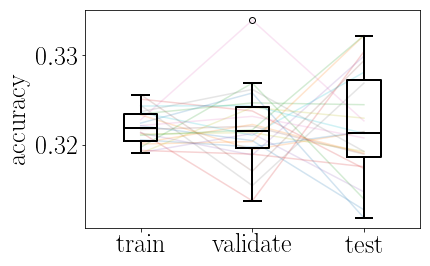

In [136]:
a = plot_hist(path)

# Марковские модели

In [54]:
from data_loading import *
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'serif', "serif":"stix",  'size': 26})
rc('text', usetex=True)

In [47]:
record = SeqIO.read("../data/ecoli.genbank", "genbank")
end = len(record.seq)
step = end//10

In [131]:
genome_l = len(record.seq)
seq_cds  = np.zeros(genome_l)
seq_non  = np.ones(genome_l)  
for f in record.features:
    if f.type == 'CDS':
        seq_cds[f.location.start: f.location.end] = 1
#         seq_non[f.location.start - 24: f.location.end + 24] = 0

In [133]:
sum(seq_cds)/genome_l

0.8793933711532015

In [48]:
def k_mer_count(seq, k):
    bases_list = ["A", "T", "C", "G"]
    counts = {}
    num_kmers = len(seq) - k # + 1 так как нужна еще следующая буква
    for i in range(num_kmers):
        kmer = seq[i:i+k]
        letter = seq[i+k]
        index = bases_list.index(letter)
        if kmer not in counts:
            counts[kmer] = [0] * 4
        counts[kmer][index] += 1
    return counts

In [58]:
accs = np.zeros((10, 10), dtype=np.float64)
for n in range(1, 10):
    print(n, end = "  ")
    for i in range(10):
        test_seq = str(record.seq[(i*step):(i*step + step)])
        train_seq = str(record.seq[:(i*step)]) + str(record.seq[(i*step + step):])
        train_counts = k_mer_count(train_seq, n)
        test_counts = k_mer_count(test_seq, n)
        rightguess = 0
        for word in test_counts.keys():
            if word in train_counts:
                if np.argmax(test_counts[word]) ==  np.argmax(train_counts[word]):
                    rightguess += np.max(test_counts[word])
            else:
                rightguess += np.mean(test_counts[word])
        p = rightguess/step
        print(i, end = "  ")
        accs[n, i] = p
        
    print(" ")

1  0  1  2  3  4  5  6  7  8  9   
2  0  1  2  3  4  5  6  7  8  9   
3  0  1  2  3  4  5  6  7  8  9   
4  0  1  2  3  4  5  6  7  8  9   
5  0  1  2  3  4  5  6  7  8  9   
6  0  1  2  3  4  5  6  7  8  9   
7  0  1  2  3  4  5  6  7  8  9   
8  0  1  2  3  4  5  6  7  8  9   
9  0  1  2  3  4  5  6  7  8  9   


In [88]:
accs1 = np.zeros((15, 10), dtype=np.float64)
accs1[0:10, ...] = accs

In [89]:
accs1.shape

(15, 10)

In [ ]:
for n in range(11, 15):
    print(n, end = "  ")
    for i in range(10):
        test_seq = str(record.seq[(i*step):(i*step + step)])
        train_seq = str(record.seq[:(i*step)]) + str(record.seq[(i*step + step):])
        train_counts = k_mer_count(train_seq, n)
        test_counts = k_mer_count(test_seq, n)
        rightguess = 0
        for word in test_counts.keys():
            if word in train_counts:
                if np.argmax(test_counts[word]) ==  np.argmax(train_counts[word]):
                    rightguess += np.max(test_counts[word])
            else:
                rightguess += np.mean(test_counts[word])
        p = rightguess/step
        print(i, end = "  ")
        accs1[n, i] = p
        
    print(" ")

11  0  1  2  3  4  5  6  7  8  9   
12  0  1  2  3  4  5  6  7  8  9   
13  0  1  2  3  4  5  6  7  8  9   
14  0  1  5  6  7  8  

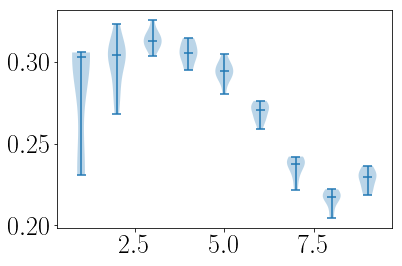

In [92]:
plt.violinplot([accs[i, ...] for i in range(1, 10)], showmedians = True)
plt.show()

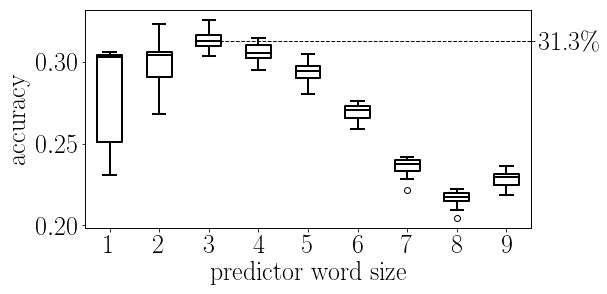

In [130]:
plt.figure(figsize = (8, 4))
plt.boxplot([accs1[i, ...] for i in range(1, 10)],
           medianprops=dict(color="black", linewidth = 2),
            boxprops=dict(linewidth = 2),
            capprops=dict(linewidth = 2),
            whiskerprops=dict(linewidth = 2),)

plt.ylabel("accuracy")
plt.xlabel("predictor word size")

ax = plt.gca()
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.tick_params(axis='y', labelleft=False, labelright=True)
ax2.set_yticks([ np.median(accs[3, ...])])
ax2.set_yticklabels(["31.3\%"])
plt.hlines([0.26], xmin = 10, xmax= 20,  linestyles='dashed', linewidth = 1)
plt.hlines([np.median(accs[3, ...])], xmin = 3, xmax = 20, linestyles='dashed', linewidth = 1)
plt.savefig("../results/pics/markov.png", dpi=300, bbox_inches='tight')
plt.show()

In [121]:
for n in range(1, 10):
    print(np.mean(accs[n, ...]), np.min(accs[n, ...]), np.max(accs[n, ...]))

0.28244999084377326 0.23105145799446317 0.30582443743065507
0.2989790268546745 0.26826451800545065 0.32321695948638957
0.3135428134391865 0.30394794954380444 0.3255394094772333
0.3054189781650921 0.2949791561190525 0.3145907166632555
0.29380371204205397 0.28055540594400696 0.30465244040373574
0.26935335494920987 0.25873127013023384 0.2762142772505467
0.23559440069802767 0.22179451272715522 0.24212995378798488
0.21617517477621107 0.20461635409821938 0.22211928947680243
0.2280896879342475 0.21850311850311852 0.23645147738411987


In [2]:
import numpy as np
import pandas as pd

In [34]:
def positions(filename = "../data/conservation/ecoli_cons_pos.tsv"):
    with open(filename, "r") as file:
        for line in file.readlines():
            fields = line.strip().split("\t")
            fields[0] = int(fields[0])
            fields[2] = eval(fields[2])
            yield fields